In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [316]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [317]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [318]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

In [319]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

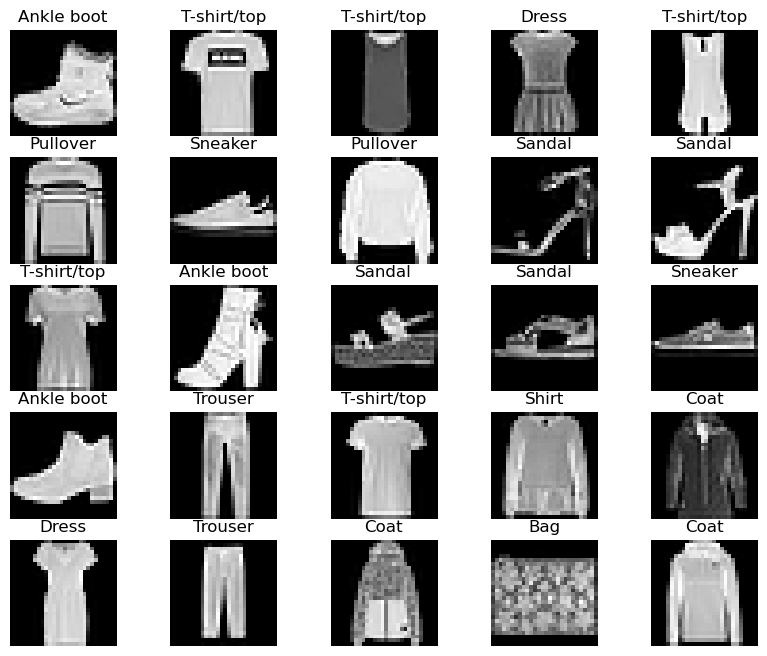

In [320]:
plt.figure(figsize=(10, 8))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.title(class_names[y_train[i]])
  plt.axis("off")

In [321]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

## Split dataset
We creae two dataset from we loaded above. The first dataset with 08 classes and second with 02 classes.

In [322]:
class_0 = class_names.index("T-shirt/top")
class_1 = class_names.index("Pullover")
class_0, class_1

(0, 2)

In [323]:
def split_dataset(X, y):
  B = (y == class_0) | (y == class_1)
  y_A = y[~B]
  y_B = (y[B] == class_1).astype(np.float32)
  old_class = list(set(range(10)) - set([class_0, class_1]))
  for old, new in zip(old_class, range(8)):
    y_A[y_A == old] = new
  return ((X[~B], y_A), (X[B], y_B))

In [324]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

X_train_B = X_train_B[:50]
y_train_B = y_train_B[:50]

In [325]:
print("Dataset shape for model A")
print("----------------------------------")
print("Training:", X_train_A.shape, y_train_A.shape)
print("Validation:", X_valid_A.shape, y_valid_A.shape)
print("Testing:", X_test_B.shape, y_test_A.shape)

Dataset shape for model A
----------------------------------
Training: (44011, 28, 28) (44011,)
Validation: (3989, 28, 28) (3989,)
Testing: (2000, 28, 28) (8000,)


In [326]:
print("Dataset shape for model B")
print("----------------------------------")
print("Training:", X_train_B.shape, y_train_B.shape)
print("Validation:", X_valid_B.shape, y_valid_B.shape)
print("Testing:", X_test_B.shape, y_test_B.shape)

Dataset shape for model B
----------------------------------
Training: (50, 28, 28) (50,)
Validation: (1011, 28, 28) (1011,)
Testing: (2000, 28, 28) (2000,)


## Train and Save model A

In [186]:
tf.random.set_seed(42)

model_A = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  
  tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  
  tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
  metrics=["accuracy"]
)

model_A.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 99508 (388.70 KB)
Trainable params: 99508 (388.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [188]:
history_A = model_A.fit(X_train_A, y_train_A, epochs=30,
                       validation_data=(X_valid_A, y_valid_A))

Epoch 1/30
  39/1376 [..............................] - ETA: 3s - loss: 0.7589 - accuracy: 0.7564

2024-02-05 15:14:42.131892: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138018496 exceeds 10% of free system memory.


1376/1376 [==============================] - 4s 3ms/step - loss: 0.6567 - accuracy: 0.7820 - val_loss: 0.5647 - val_accuracy: 0.8162
Epoch 2/30
1376/1376 [==============================] - 4s 3ms/step - loss: 0.5282 - accuracy: 0.8244 - val_loss: 0.4800 - val_accuracy: 0.8378
Epoch 3/30
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4588 - accuracy: 0.8509 - val_loss: 0.4276 - val_accuracy: 0.8571
Epoch 4/30
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4136 - accuracy: 0.8659 - val_loss: 0.3923 - val_accuracy: 0.8679
Epoch 5/30
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3820 - accuracy: 0.8760 - val_loss: 0.3675 - val_accuracy: 0.8729
Epoch 6/30
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3590 - accuracy: 0.8811 - val_loss: 0.3489 - val_accuracy: 0.8797
Epoch 7/30
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3419 - accuracy: 0.8862 - val_loss: 0.3350 - val_accuracy: 0.8804
Epo

Text(0.5, 1.0, 'Accuracy')

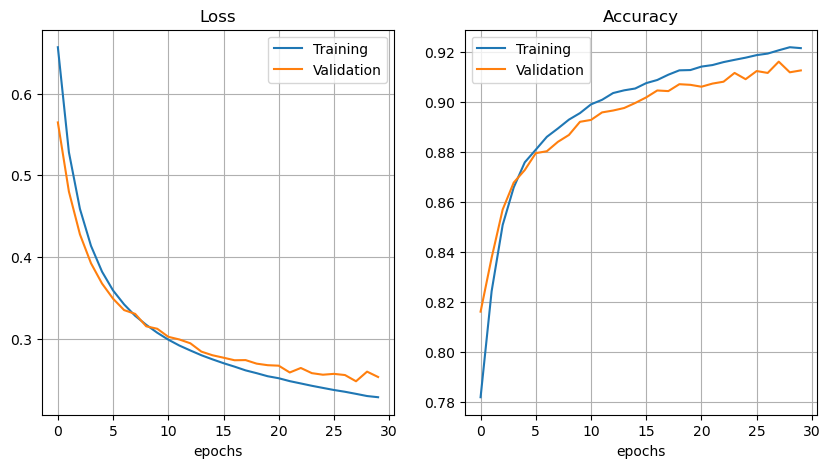

In [213]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

plt.sca(axes[0])
plt.plot(history_A.history["loss"], label="Training")
plt.plot(history_A.history["val_loss"], label="Validation")
plt.legend()
plt.grid()
plt.xlabel("epochs")
plt.title("Loss")

plt.sca(axes[1])
plt.plot(history_A.history["accuracy"], label="Training")
plt.plot(history_A.history["val_accuracy"], label="Validation")
plt.legend()
plt.grid()
plt.xlabel("epochs")
plt.title("Accuracy")

In [214]:
model_A.evaluate(X_test_A, y_test_A)

250/250 [==============================] - 1s 2ms/step - loss: 0.2687 - accuracy: 0.9011


[0.2686651051044464, 0.9011250138282776]

In [216]:
model_A.save("Models/Model_A")

INFO:tensorflow:Assets written to: Models/Model_A/assets


INFO:tensorflow:Assets written to: Models/Model_A/assets


## Train and Evaluate Model B from scrath

In [300]:
tf.random.set_seed(42)

model_B = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  
  tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
  metrics=["accuracy"]
)

model_B.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_33 (Dense)            (None, 100)               78500     
                                                                 
 dense_34 (Dense)            (None, 100)               10100     
                                                                 
 dense_35 (Dense)            (None, 100)               10100     
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 98801 (385.94 KB)
Trainable params: 98801 (385.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [301]:
history_B = model_B.fit(X_train_B, y_train_B, epochs=30,
                       validation_data=(X_valid_B, y_valid_B))

Epoch 1/30
2/2 [==============================] - 1s 247ms/step - loss: 0.8102 - accuracy: 0.3000 - val_loss: 0.7905 - val_accuracy: 0.3017
Epoch 2/30
2/2 [==============================] - 0s 94ms/step - loss: 0.8000 - accuracy: 0.3600 - val_loss: 0.7821 - val_accuracy: 0.3155
Epoch 3/30
2/2 [==============================] - 0s 89ms/step - loss: 0.7895 - accuracy: 0.3600 - val_loss: 0.7746 - val_accuracy: 0.3432
Epoch 4/30
2/2 [==============================] - 0s 91ms/step - loss: 0.7792 - accuracy: 0.4200 - val_loss: 0.7668 - val_accuracy: 0.3531
Epoch 5/30
2/2 [==============================] - 0s 104ms/step - loss: 0.7694 - accuracy: 0.4200 - val_loss: 0.7591 - val_accuracy: 0.3699
Epoch 6/30
2/2 [==============================] - 0s 105ms/step - loss: 0.7594 - accuracy: 0.4200 - val_loss: 0.7523 - val_accuracy: 0.3927
Epoch 7/30
2/2 [==============================] - 0s 111ms/step - loss: 0.7503 - accuracy: 0.4200 - val_loss: 0.7454 - val_accuracy: 0.4095
Epoch 8/30
2/2 [=======

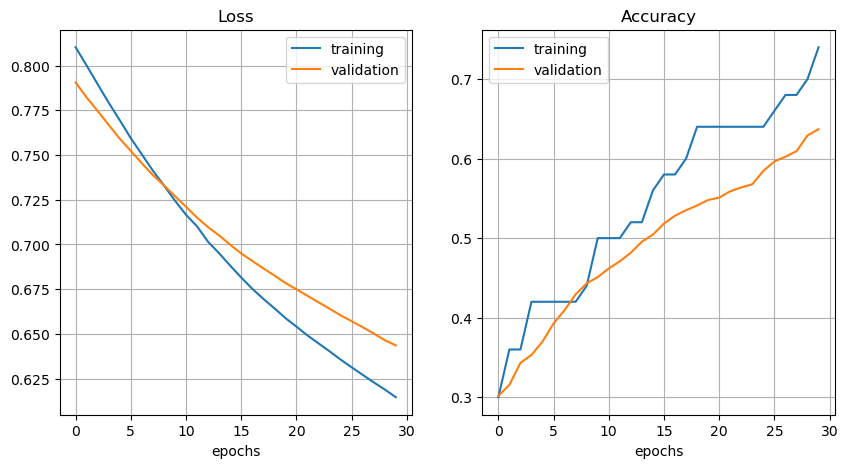

In [302]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

plt.sca(axes[0])
plt.plot(history_B.history["loss"], label="training")
plt.plot(history_B.history["val_loss"], label="validation")
plt.legend()
plt.grid()
plt.title("Loss")
plt.xlabel("epochs")

plt.sca(axes[1])
plt.plot(history_B.history["accuracy"], label="training")
plt.plot(history_B.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.grid()
plt.legend()

In [303]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.6478 - accuracy: 0.6295


[0.6478413939476013, 0.6294999718666077]

## Train model B from saved model A 

In [327]:
model_A = tf.keras.models.load_model("Models/Model_A")
model_A.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 99508 (388.70 KB)
Trainable params: 99508 (388.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [328]:
tf.random.set_seed(42)

clone_model_A = tf.keras.models.clone_model(model_A)
clone_model_A.set_weights(model_A.get_weights())
clone_model_A.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 99508 (388.70 KB)
Trainable params: 99508 (388.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


First freeze the reused layers and train it during the first few epochs before unfreeze and train it

In [329]:
model_BA = tf.keras.Sequential(clone_model_A.layers[:-1])
model_BA.add(
  tf.keras.layers.Dense(1, activation="sigmoid")
)

for layer in model_BA.layers[:-1]:
  layer.trainable = False

model_BA.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
  metrics=["accuracy"]
)

model_BA.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_39 (Dense)            (None, 1)                 101       
                                                                 
Total params: 98801 (385.94 KB)
Trainable params: 101 (404.00 Byte)
Non-trainable params: 98700 (385.55 KB)
_________________________________________________________________


In [330]:
history_BA = model_BA.fit(X_train_B, y_train_B, epochs=5,
                         validation_data=(X_valid_B, y_valid_B))

Epoch 1/5
2/2 [==============================] - 1s 238ms/step - loss: 0.7727 - accuracy: 0.4800 - val_loss: 0.7526 - val_accuracy: 0.4768
Epoch 2/5
2/2 [==============================] - 0s 97ms/step - loss: 0.7676 - accuracy: 0.4800 - val_loss: 0.7427 - val_accuracy: 0.4777
Epoch 3/5
2/2 [==============================] - 0s 194ms/step - loss: 0.7577 - accuracy: 0.5000 - val_loss: 0.7370 - val_accuracy: 0.4985
Epoch 4/5
2/2 [==============================] - 0s 115ms/step - loss: 0.7510 - accuracy: 0.5000 - val_loss: 0.7306 - val_accuracy: 0.5045
Epoch 5/5
2/2 [==============================] - 0s 112ms/step - loss: 0.7454 - accuracy: 0.5000 - val_loss: 0.7235 - val_accuracy: 0.5084


In [331]:
for layer in model_BA.layers[:-1]:
  layer.trainable = True

model_BA.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
  metrics=["accuracy"]
)

model_BA.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_39 (Dense)            (None, 1)                 101       
                                                                 
Total params: 98801 (385.94 KB)
Trainable params: 98801 (385.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [332]:
history_BA = model_BA.fit(X_train_B, y_train_B, epochs=30,
                         validation_data=(X_valid_B, y_valid_B))

Epoch 1/30
2/2 [==============================] - 1s 227ms/step - loss: 0.7367 - accuracy: 0.4800 - val_loss: 0.7030 - val_accuracy: 0.5638
Epoch 2/30
2/2 [==============================] - 0s 88ms/step - loss: 0.7157 - accuracy: 0.5400 - val_loss: 0.6773 - val_accuracy: 0.5786
Epoch 3/30
2/2 [==============================] - 0s 100ms/step - loss: 0.6863 - accuracy: 0.6000 - val_loss: 0.6579 - val_accuracy: 0.6340
Epoch 4/30
2/2 [==============================] - 0s 91ms/step - loss: 0.6628 - accuracy: 0.6400 - val_loss: 0.6394 - val_accuracy: 0.6677
Epoch 5/30
2/2 [==============================] - 0s 153ms/step - loss: 0.6440 - accuracy: 0.6800 - val_loss: 0.6207 - val_accuracy: 0.6855
Epoch 6/30
2/2 [==============================] - 0s 99ms/step - loss: 0.6237 - accuracy: 0.7000 - val_loss: 0.6059 - val_accuracy: 0.7250
Epoch 7/30
2/2 [==============================] - 0s 88ms/step - loss: 0.6071 - accuracy: 0.7600 - val_loss: 0.5902 - val_accuracy: 0.7280
Epoch 8/30
2/2 [========

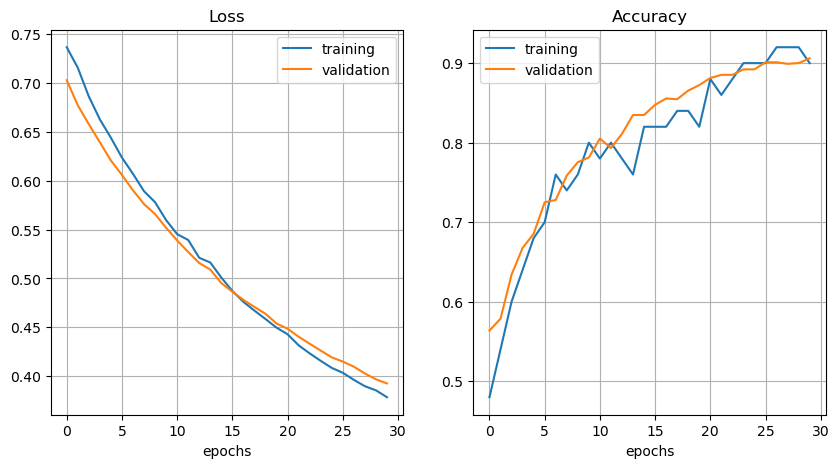

In [333]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

plt.sca(axes[0])
plt.plot(history_BA.history["loss"], label="training")
plt.plot(history_BA.history["val_loss"], label="validation")
plt.legend()
plt.grid()
plt.title("Loss")
plt.xlabel("epochs")

plt.sca(axes[1])
plt.plot(history_BA.history["accuracy"], label="training")
plt.plot(history_BA.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.grid()
plt.legend()

In [334]:
model_BA.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.4051 - accuracy: 0.8925


[0.4050861597061157, 0.8924999833106995]

# We can see that the model B trained from model A is more better than the model B trained from scratch